In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fiona.crs import from_epsg
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [95]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

# Merged shape
merged_shape_folder = cs.read_from_config(config_file, 'merged_shp_dir')
merged_shape_name   = cs.read_from_config(config_file, 'merged_shp_name')

# Get the attribute folder
att_folder = cs.read_from_config(config_file, 'att_path')

# Projection
img_crs =  cs.read_from_config(config_file, 'equal_area_crs')

# Image output folder
image_folder = cs.read_from_config(config_file, 'image_path')

In [110]:
# Specify the paths
merged_shape_path = Path(data_path) / cs_basin_folder / merged_shape_folder
merged_shape_path.mkdir(parents=True, exist_ok=True)

basin_path = Path(data_path) / cs_basin_folder / 'basin_data' # This should exist at this point of the workflow

att_path = Path(data_path) / cs_basin_folder / att_folder / 'PET_analysis'

image_path = Path(image_folder)
image_path.mkdir(exist_ok=True, parents=True)

### Data loading

In [5]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name, dtype={'Station_id': object})

# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object})

# Attributes
cs_att_path = Path(data_path) / cs_meta_path / 'camels_spat_attributes.csv'
cs_att = pd.read_csv(cs_att_path,low_memory=False)

In [6]:
# Transpose the attributes for easier merging with GDF
cs_att = cs_att.transpose()
headers = cs_att.iloc[1] # we just keep the attribute name because with multiple header levels the merging fails
cs_att = cs_att.iloc[4:]
cs_att.columns = headers.values.tolist()

In [116]:
# Get the calculated PET stats and load into a dataframe
pet_files = glob.glob(str(att_path / 'pet_stats_*.csv'))

pet_dfs = []
for filename in pet_files:
    df = pd.read_csv(filename)
    pet_dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
pet_df = pd.concat(pet_dfs, axis=0)

### Create the merged shape
We want the following attributes:
- Climate
    - Long-term aridity and fraction snow
    - Standard deviation of both in space (WorldClim) and time (ERA5)

#### Create a geodataframe we'll re-use for plotting

In [7]:
# Loop over the metadata to find -all- the lumped shapes
geometries = []
for ix,row in cs_meta.iterrows():
    
    # Construct the path to the lumped shapefile
    basin_str = '_'.join([row['Country'],row['Station_id']])
    lumped_shp = basin_path / basin_str / 'shapefiles' / 'lumped' / (basin_str + '_lumped.shp')
    
    # Open the shape and get the geometry
    shp = gpd.read_file(lumped_shp)
    geometries.append(shp.geometry.values[0])

In [8]:
# Get the attributes from the metadata
meta_attributes = cs_meta[['Country','Station_id','Station_name']].copy()

In [9]:
# Add the geometries
meta_attributes['geometry'] = geometries

In [10]:
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(meta_attributes, crs=None)

In [11]:
# Set the CRS
gdf.crs = from_epsg(4326)

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/proj/9.0.0/lib/python3.10/site-packages/pyproj-3.3.0-py3.10-linux-x86_64.egg/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
# Remove the stations we don't want
not_these = cs_unusable['Station_id'].unique() # we have some duplicates in here, this removes those
gdf = gdf[~gdf['Station_id'].isin(not_these)]
gdf = gdf.reset_index(drop=True)

In [13]:
# Create the variable we'll use for merging: <country>_<id>
gdf['basin_id'] = gdf.apply(lambda row: row['Country'] + '_' + row['Station_id'], axis=1)

In [14]:
# Project the basins into the projection we want for this graphic
gdf = gdf.to_crs(img_crs)

In [15]:
# Convert the polygons to point locations - these make for better plots when the figure is smaller
gdf['geometry'] = gdf['geometry'].centroid

#### Add the geospatial attributes we're interested in

In [125]:
# Update the PET dataframe from mm day-1 to mm year-1
pet_df = pet_df.set_index('basin_id')*365
pet_df['era5_long_mean_e'] = pet_df['era5_long_mean_e'] * -1
pet_df['era5_annual_mean_e'] = pet_df['era5_annual_mean_e'] * -1

In [126]:
# Select the WorldClim variables from the main attribute file
att_columns = ('prec_mean', 'pet2_mean', 'aridity2_mean')
gdf_clim = pd.merge(gdf, cs_att.loc[:,att_columns].astype('float'), left_on='basin_id', right_on=cs_att.index)

In [127]:
gdf_clim = pd.merge(gdf_clim,pet_df, left_on='basin_id', right_on=pet_df.index)

In [132]:
# Rename WorldCLim
gdf_clim = gdf_clim.rename(columns={'prec_mean': 'wc_long_mean_p',
                             'pet2_mean': 'wc_long_mean_e',
                             'aridity2_mean': 'wc_aridity'})

In [134]:
# Define aridity where we don't have it yet
gdf_clim['rdrs_aridity'] = gdf_clim['rdrs_long_mean_e'] / gdf_clim['rdrs_long_mean_p']
gdf_clim['era5_aridity'] = gdf_clim['era5_long_mean_e'] / gdf_clim['era5_long_mean_p']
gdf_clim['daymet_aridity'] = gdf_clim['daymet_long_mean_e'] / gdf_clim['daymet_long_mean_p']

In [175]:
# Count the negative total PET occurrences in ERA5
(gdf_clim['era5_annual_mean_e'] < 0).sum()

116

### Figures
We'll also add some nation, state, province and territory boundaries (CEC, 2022). This is a pretty hefty download so we'll exclude these files from the repo and simply build in a flag below to not plot the background shapes if they are not available on the system.

**Reference**

Commission for Environmental Cooperation (CEC). 2022. “North American Atlas – Political Boundaries”. Statistics Canada, United States Census Bureau, Instituto Nacional de Estadística y Geografía (INEGI). Ed. 3.0, Vector digital data [1:10,000,000]. Available at http://www.cec.org/north-american-environmental-atlas/political-boundaries-2021/. Accessed 2023-12-20

In [17]:
border_path = cs_meta_path / 'TEMP_PoliticalBoundaries_Shapefile/NA_PoliticalDivisions/data/bound_p/boundaries_p_2021_v3.shp'

In [18]:
# Check if we have the boundary file and act accordingly
have_borders = False
if os.path.exists(border_path):
    have_borders = True
    gdf_borders = gpd.read_file(border_path)
    gdf_borders = gdf_borders.to_crs(img_crs)

#### Generalized plotting function

In [19]:
def disable_box_boundaries(ax):
    ax.set_xlim([-2.5*1e6, 3.1*1e6])
    ax.set_ylim([-1.6*1e6, 3.7*1e6])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [162]:
def add_histogram(ax,bbox,gdf,column,bar_scale,bins=10,extra=None):
    # Make the extra axis
    hax = inset_axes(ax, width='100%', height='100%', bbox_to_anchor=bbox, bbox_transform=ax.transAxes, loc=4)
    
    # Add the histogram
    gdf[column].plot.hist(ax=hax, color='0.3', rwidth=bar_scale, bins=bins)#, edgecolor='w')

    # Disable top, right, and bottom spines
    hax.spines['top'].set_visible(False)
    hax.spines['right'].set_visible(False)
    hax.spines['left'].set_visible(False)

    # (Re)move y-axis ticks and labels
    hax.set_ylabel('')
    hax.set_yticks([])
    hax.set_yticklabels([]);

    # Category-specific modifications:
    if extra == 'sand_content':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    elif extra == 'sand_std':
        hax.set_xticks([50,100,150])
        hax.set_xticklabels(['50','','150'])
    elif extra == 'pet_mean':
        hax.set_xticks([250,500,750])
        hax.set_xticklabels(['250','','750'])
    elif extra == 'wc_p':
        hax.set_xticks([2500])
        hax.set_xticklabels(['2500'])
    elif extra == 'pet':
        hax.set_xticks([0,1000,2000])
        hax.set_xticklabels(['0','1000','2000'])
    
    return

In [21]:
legend_scale = 0.6
legend_kwds = {'shrink':legend_scale,
               'orientation': 'horizontal', 
               'pad': 0.01}
poly_width = 0.1
poly_edge = 'k'
markersize = 10

map_color = '0.65'

hist_loc = (.8, .075, .25, .25)
hist_bar_scale = 0.75

#### Disable deprecation warnings
```
/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
```

In [22]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

/tmp/ipykernel_732245/4234736203.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


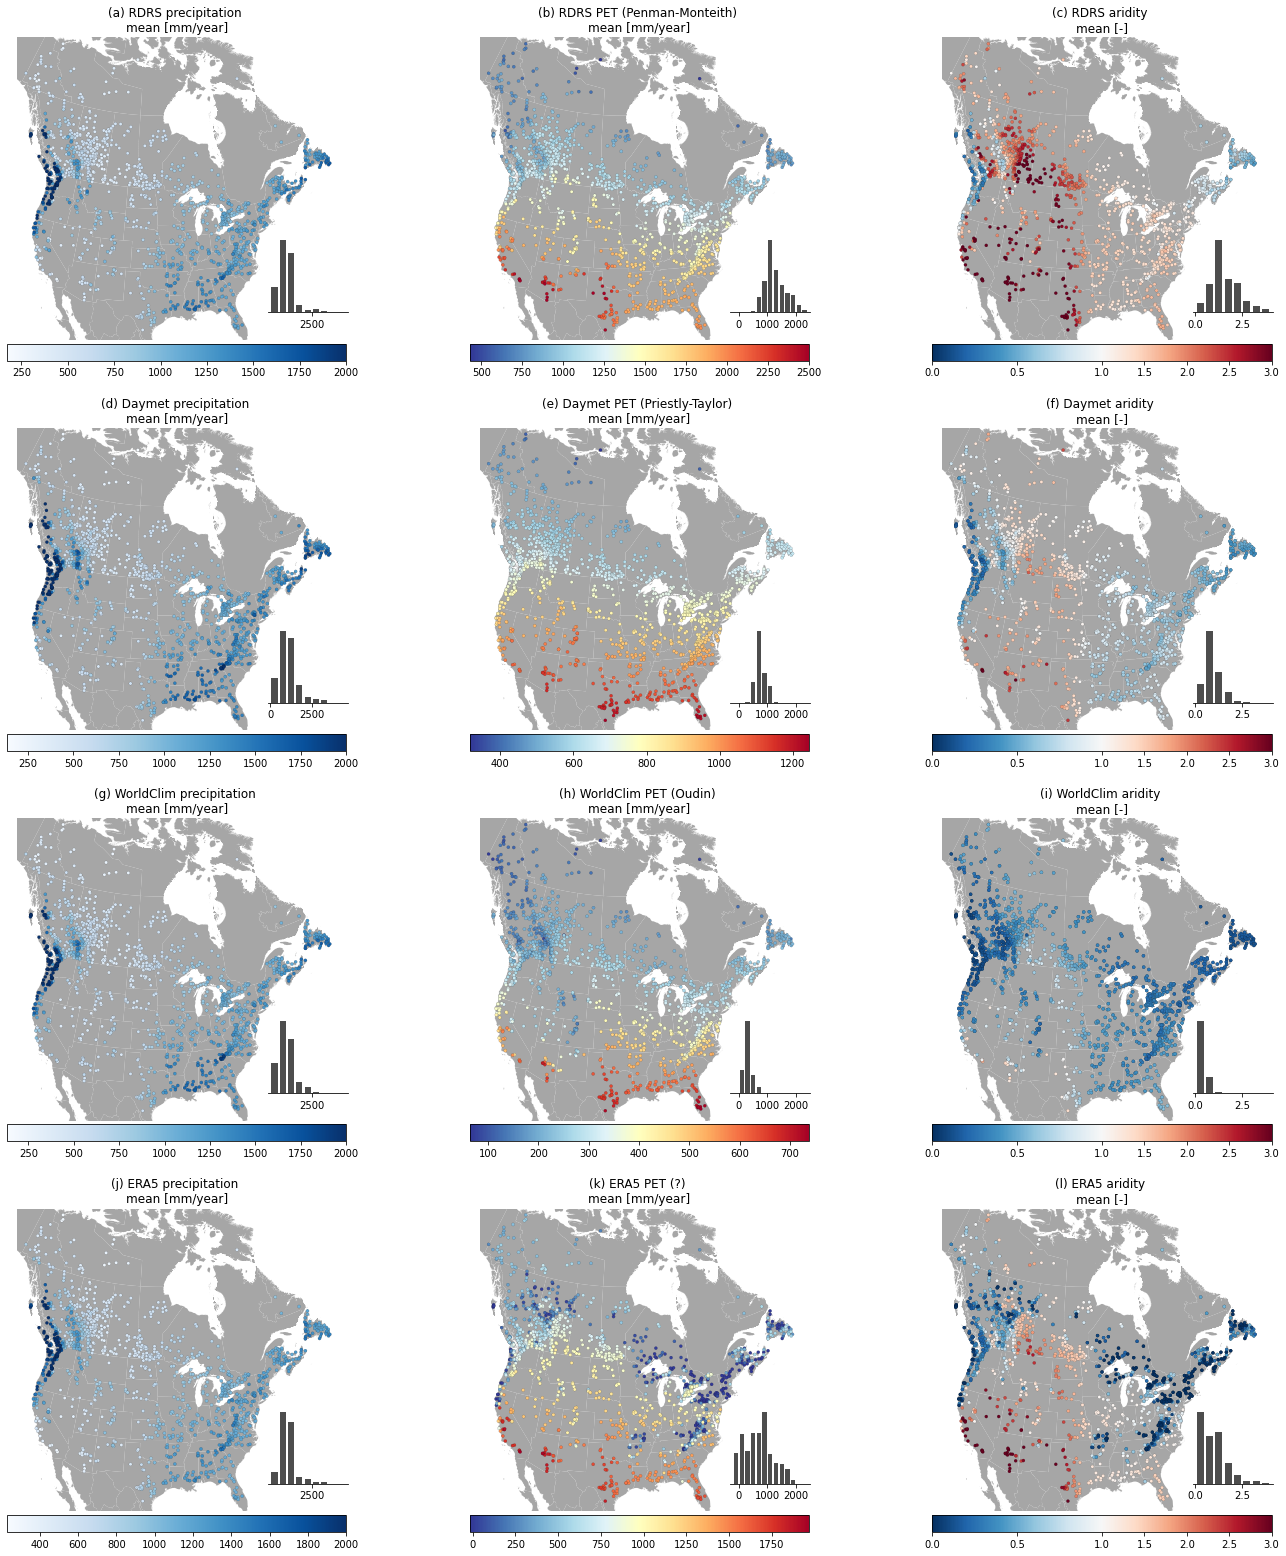

In [170]:
fig, axs = plt.subplots(4,3,figsize=(21,22))
have_borders=True

# --- RDRS
# (a) mean P
ax = axs[0,0]; color = 'Blues'; column = 'rdrs_long_mean_p'; vmax=2000
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,extra='wc_p',bins=np.linspace(0,4500,num=10))
ax.set_title('(a) RDRS precipitation \nmean [mm/year]')

# (b) mean PET
ax = axs[0,1]; color = 'RdYlBu_r'; column = 'rdrs_long_mean_e'; vmax=2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(-200,2400,num=14),extra='pet')
ax.set_title('(b) RDRS PET (Penman-Monteith) \nmean [mm/year]')

# (c) aridity
ax = axs[0,2]
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'rdrs_aridity'
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
         cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
         legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp[column]<1].sort_values(by=column, ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(c) RDRS aridity \nmean [-]')

# --- Daymet 
# (d) mean P
ax = axs[1,0]; color = 'Blues'; column = 'daymet_long_mean_p'; vmax=2000
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4500,num=10))
ax.set_title('(d) Daymet precipitation \nmean [mm/year]')

# (e) mean PET
ax = axs[1,1]; color = 'RdYlBu_r'; column = 'daymet_long_mean_e';# vmax=2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, # vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(-200,2400,num=14),extra='pet')
ax.set_title('(e) Daymet PET (Priestly-Taylor) \nmean [mm/year]')

# (f) aridity
ax = axs[1,2]
color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'daymet_aridity'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
           cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
           legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp[column]<1].sort_values(by=column, ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(f) Daymet aridity \nmean [-]')

# --- WorldClim
# (g) mean P
ax = axs[2,0]; color = 'Blues'; column = 'wc_long_mean_p'; vmax=2000
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,extra='wc_p',bins=np.linspace(0,4500,num=10))
ax.set_title('(g) WorldClim precipitation \nmean [mm/year]')

# (h) mean PET
ax = axs[2,1]; color = 'RdYlBu_r'; column = 'wc_long_mean_e';# vmax=2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, # vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(-200,2400,num=14),extra='pet')
ax.set_title('(h) WorldClim PET (Oudin) \nmean [mm/year]')

# (i) aridity
ax = axs[2,2]
color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'wc_aridity'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
           cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
           legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp[column]<1].sort_values(by=column, ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(i) WorldClim aridity \nmean [-]')

# --- ERA5
# (j) mean P
ax = axs[3,0]; color = 'Blues'; column = 'era5_long_mean_p'; vmax=2000
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, vmax=vmax, edgecolor=poly_edge, linewidth=poly_width, 
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,extra='wc_p',bins=np.linspace(0,4500,num=10))
ax.set_title('(j) ERA5 precipitation \nmean [mm/year]')

# (k) mean PET
ax = axs[3,1]; color = 'RdYlBu_r'; column = 'era5_long_mean_e';# vmax=2500
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
gdf_clim.sort_values(by=column).plot(ax=ax, column=column, markersize=markersize, 
                                     cmap=color, edgecolor=poly_edge, linewidth=poly_width, # vmax=vmax,
                                     legend=True, legend_kwds=legend_kwds)
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(-200,2400,num=14),extra='pet')
ax.set_title('(k) ERA5 PET (?) \nmean [mm/year]')

# (l) aridity
ax = axs[3,2]
color = 'RdBu_r'; divnorm = colors.TwoSlopeNorm(vmin=0., vcenter=1, vmax=3); column = 'era5_aridity'
if have_borders: gdf_borders.plot(ax=ax,facecolor=map_color,edgecolor=None, linewidth=0)
tmp = gdf_clim.sort_values(by=column) # Sort ascending: 0 values plotted first (at the bottom)
tmp.plot(ax=ax, column=column, markersize=markersize, 
           cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width, 
           legend=True, legend_kwds=legend_kwds) # plot the whole thing, lowest aridity at the bottom
tmp[tmp[column]<1].sort_values(by=column, ascending=False).plot(ax=ax, column=column, markersize=markersize, # add low aridity values in reverse order
                                                                                   cmap=color, norm=divnorm, edgecolor=poly_edge, linewidth=poly_width) 
disable_box_boundaries(ax)
add_histogram(ax,hist_loc,gdf_clim,column,hist_bar_scale,bins=np.linspace(0,4,num=9))
ax.set_title('(l) ERA5 aridity \nmean [-]')

plt.tight_layout()
plt.savefig(image_path / 'SI_PET_comparison.png', dpi=300, bbox_inches='tight')